<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/11_1_analyze_semantic_stimuli_before_experiment_using_word_embedding_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

When we plan to do a neuroimaging experiment, how do we estimate the effect size or just the effect we hypothesize to find? This script is to show a working pipeline to sample a subset of all the stimuli that we collected from some prior studies. In this case, the stimuli are words in English and Spanish. 

# Import some of the required files and documents

## - The data frame of the stimuli -- with some other attributions
## - The word-embedding model -- fast text for its easily importing from online recourses
## - no brain data

In [1]:
!git clone https://github.com/nmningmei/uncon_semantic.git

fatal: destination path 'uncon_semantic' already exists and is not an empty directory.


In [2]:
!pip install fasttext

# look at the data frames of all 380 words

## some properties:

- living v.s. nonlving
- English and Spanish
- Attributes like valence, arousal, familarity, concreteness
- Other attributes like word frequency, length

In [3]:
import os
import fasttext
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.spatial import distance
from matplotlib import pyplot as plt
%matplotlib inline

working_dir = 'uncon_semantic/data'
working_data = os.path.join(working_dir,'Affective norms for 380 Spanish words belonging to three different semantic categories.xls')
df = pd.read_excel(working_data,)

In [4]:
df.columns

Index(['Category', 'Word', 'Mean\nValence', 'SD\nValence', 'Mean\nArousal',
       'SD\nArousal', 'Mean\nFamiliarity', 'SD\nFamiliarity',
       'Mean\nConcreteness', 'SD\nConcreteness', 'Frequency', 'Length',
       'English'],
      dtype='object')

In [5]:
df = df.drop_duplicates(['English'])
df = df[df['Frequency'] != 0]
df = df[np.logical_or(df['Category'] == 'animal',df['Category'] == 'object')]

df.loc[:,'log_frequency'] = np.log(df['Frequency'].values)

## To visualize the data by living v.s. nonlving categories

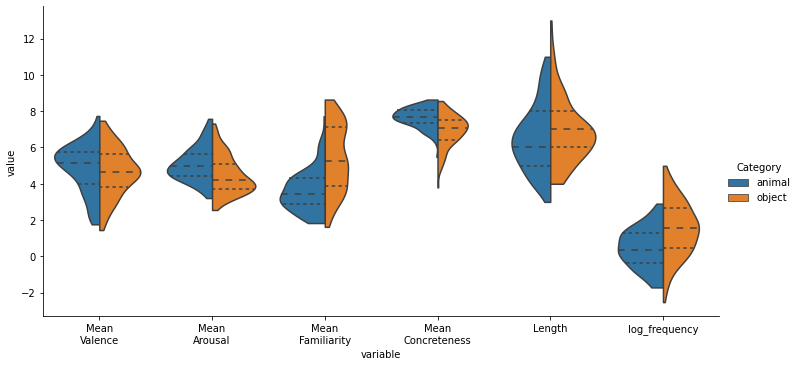

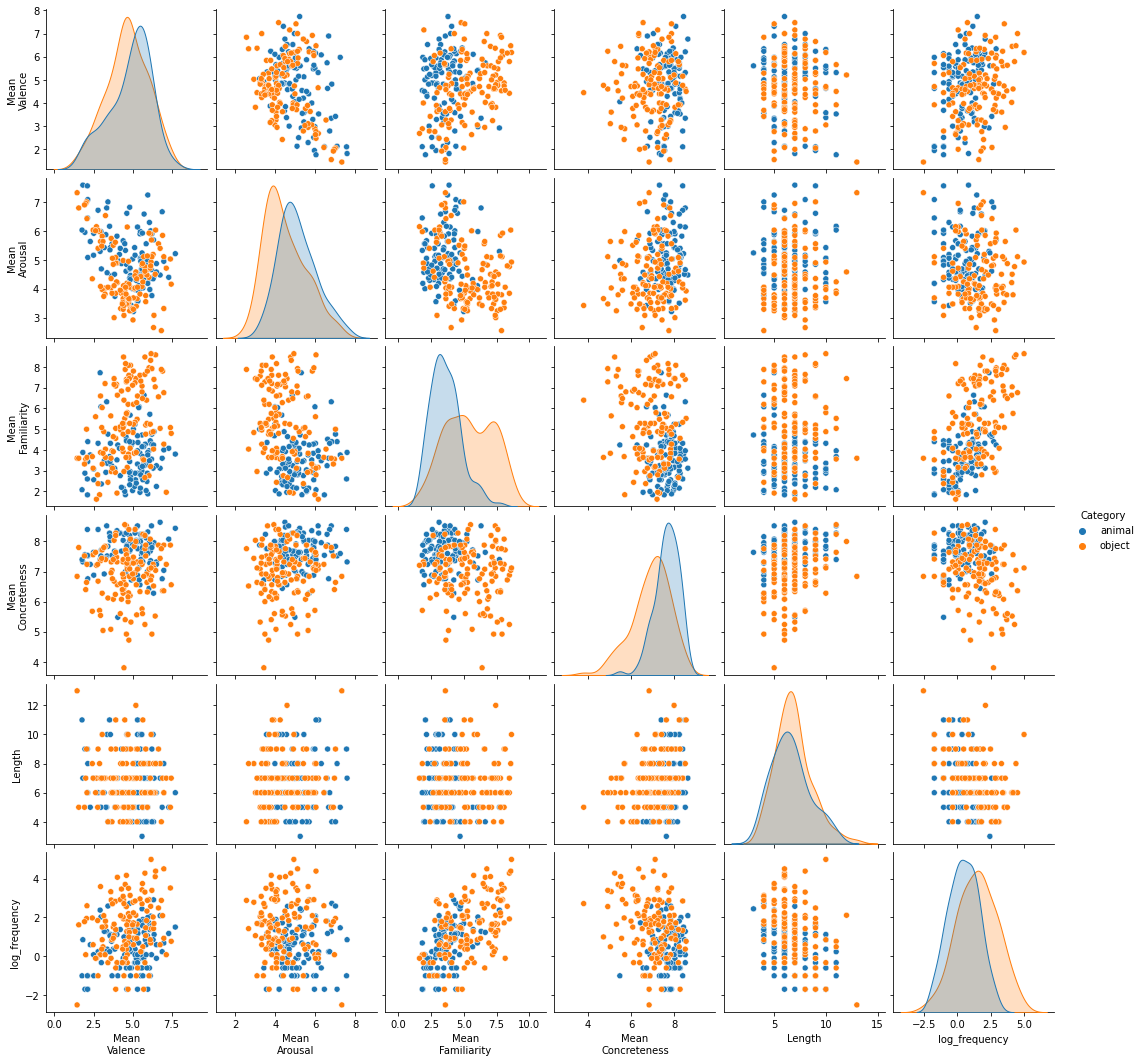

In [6]:
df_violin = pd.melt(df,id_vars = ["Category"],
                    value_vars = ['Mean\nValence',
                                  'Mean\nArousal',
                                  'Mean\nFamiliarity',
                                  'Mean\nConcreteness',
                                  'Length',
                                  'log_frequency'])

sns.catplot(x = "variable",
            y = "value",
            hue = "Category",
            data = df_violin,
            kind = "violin",
            aspect = 2,
            **{"cut":0,
               "inner":"quartile",
               "split":True})
g = sns.pairplot(df,
                 hue = 'Category',
                 vars = ['Mean\nValence',
                         'Mean\nArousal',
                         'Mean\nFamiliarity',
                         'Mean\nConcreteness',
                         'Length',
                         'log_frequency'],
                 diag_kind = 'kde')

## subsample the words

In [7]:
df_animal = df[df['Category'] == 'animal']
df_object = df[df['Category'] == 'object']
df_animal['picked'] = np.logical_and(df_animal['Mean\nFamiliarity'].apply(lambda x: 2.5<=x<=5.5),
                                     df_animal['Mean\nConcreteness'].apply(lambda x: 5.5<=x<=8.5))
df_object['picked'] = np.logical_and(df_object['Mean\nFamiliarity'].apply(lambda x: 2.5<=x<=5.5),
                                     df_object['Mean\nConcreteness'].apply(lambda x: 5.5<=x<=8.5))
lower_bound = np.min([np.sum(df_animal['picked']),np.sum(df_object['picked'])])
print('sample {lower_bound} words'.format(lower_bound=lower_bound))

sample 62 words


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


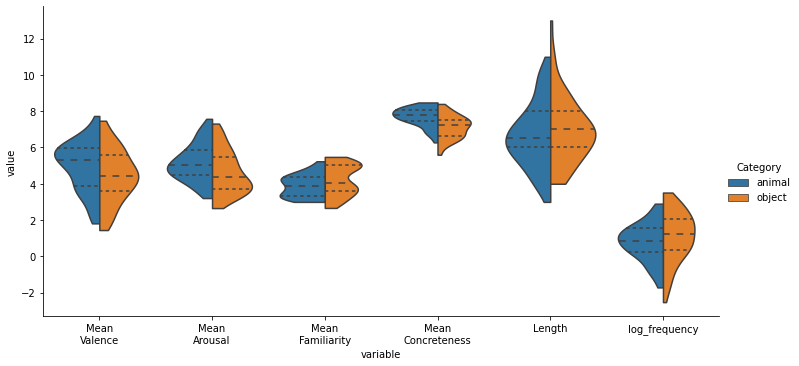

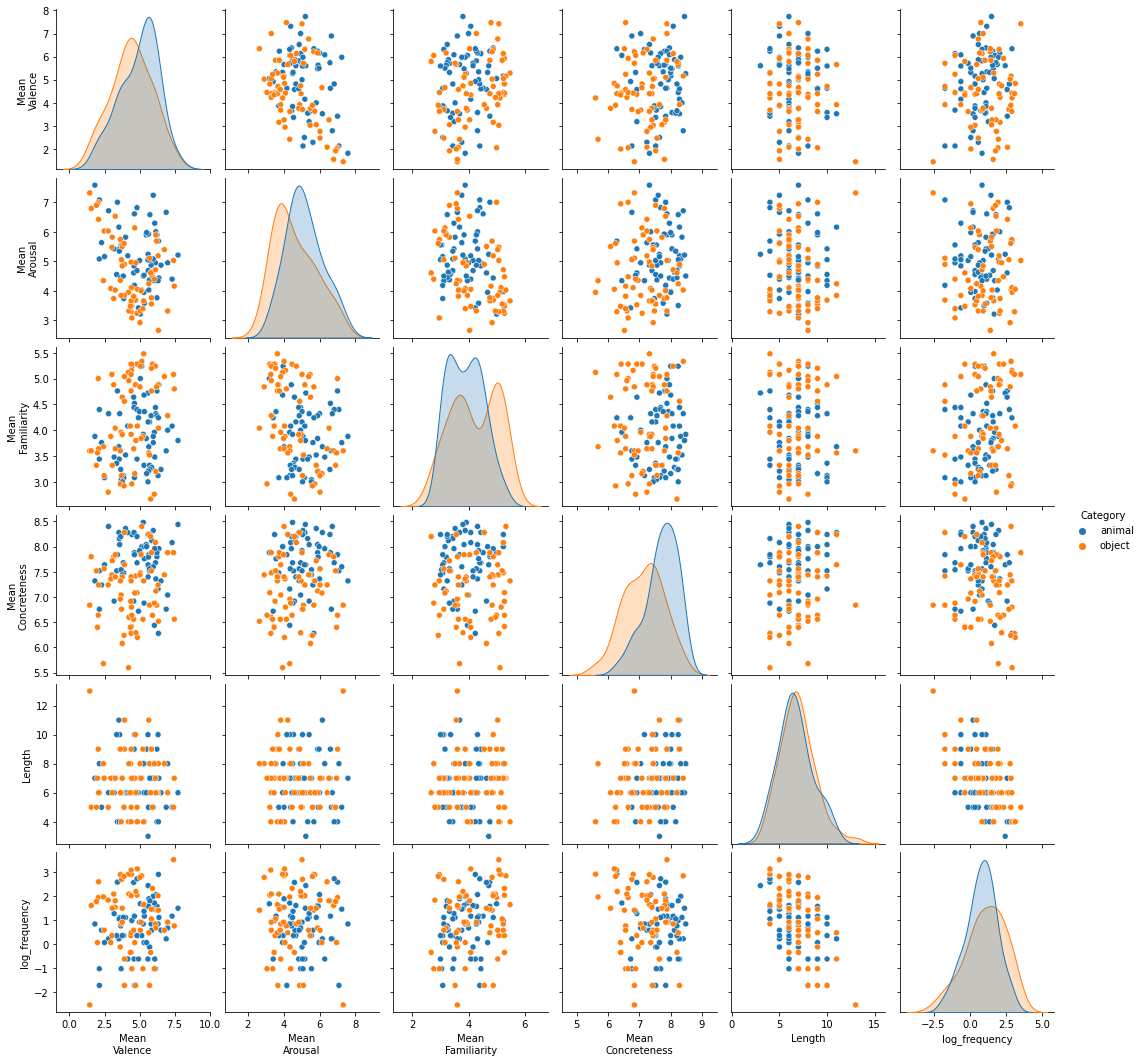

In [8]:
df_animal = df_animal[df_animal['picked']]
df_object = df_object[df_object['picked']]
df_animal = df_animal.nlargest(lower_bound,'Mean\nFamiliarity')
df_object = df_object.nlargest(lower_bound,'Mean\nFamiliarity')
df_final = pd.concat([df_animal,df_object])

df_violin = pd.melt(df_final,id_vars = ["Category"],
                    value_vars = ['Mean\nValence',
                                  'Mean\nArousal',
                                  'Mean\nFamiliarity',
                                  'Mean\nConcreteness',
                                  'Length',
                                  'log_frequency'])

sns.catplot(x = "variable",
            y = "value",
            hue = "Category",
            data = df_violin,
            kind = "violin",
            aspect = 2,
            **{"cut":0,
               "inner":"quartile",
               "split":True})

g = sns.pairplot(df_final,
                 hue = 'Category',
                 vars = ['Mean\nValence',
                         'Mean\nArousal',
                         'Mean\nFamiliarity',
                         'Mean\nConcreteness',
                         'Length',
                         'log_frequency'],
                 diag_kind = 'kde')

## download the word embedding models for English and Spanish. For detailed documentation: https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
# English -- this cell will take forever to run
if not os.path.exists('cc.en.300.bin'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    !gunzip cc.en.300.bin.gz
!rm *gz
english = fasttext.load_model('cc.en.300.bin')

temp = dict()
for word in df['English'].values:
    temp[word] = english.get_word_vector(word)
df_english_reps = pd.DataFrame(temp)
del english
!rm *bin

--2020-12-05 14:19:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz      0%[                    ]  31.59M   221KB/s    eta 1h 42m 

In [ ]:
# Spanish -- this cell will take forever to run, too
if not os.path.exists('cc.es.300.bin'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
    !gunzip cc.es.300.bin.gz
!rm *gz
spanish = fasttext.load_model('cc.es.300.bin')

temp = dict()
for word in df['Word'].values:
    temp[word] = spanish.get_word_vector(word)
df_spanish_reps = pd.DataFrame(temp)
del spanish
!rm *bin

In [ ]:
df = df.sort_values(['Category','Word'])
df['Spanish'] = df['Word']
spanish = df['Word'].values
categories = df['Category'].values
english = df['English'].values
word_vecs_english = np.array([df_english_reps[word] for word in english])
word_vecs_spanish = np.array([df_spanish_reps[word] for word in spanish])

In [ ]:
for word_vecs,language in zip([word_vecs_english,word_vecs_spanish],
                              ['English','Spanish']):
    RDM = distance.squareform(distance.pdist(word_vecs - word_vecs.mean(1).reshape(-1,1),'cosine'))
    RDM_copy = RDM.copy()
    np.fill_diagonal(RDM,np.nan)
    labels = df[language].values.copy()
    df_plot = pd.DataFrame(RDM,index = labels,columns = labels)
    np.fill_diagonal(RDM_copy,0)
    df_cluster = pd.DataFrame(RDM_copy,index = labels,columns = labels)

    fig,ax = plt.subplots(figsize = (30,30))
    ax = sns.heatmap(df_plot,
                    xticklabels = True,
                    yticklabels = True,
                    square = True,
                    ax = ax,
                    cmap = plt.cm.coolwarm,
                    vmax = 1.2,
                    )
    ax.axvline(df_plot.shape[0] / 2, linestyle = '--',color = 'black',alpha = 1.)
    ax.axhline(df_plot.shape[0] / 2, linestyle = '--',color = 'black',alpha = 1.)
    ax.set(title = language)

    g = sns.clustermap(df_cluster,
                       figsize = (30,30),
                       xticklabels = True,
                       yticklabels = True,
                       cmap = plt.cm.coolwarm,)
    g.fig.suptitle(language)

In [ ]:
df_final = df_final.sort_values(['Category','Word'])
df_final['Spanish'] = df_final['Word']
spanish = df_final['Word'].values
categories = df_final['Category'].values
english = df_final['English'].values
word_vecs_english = np.array([df_english_reps[word] for word in english])
word_vecs_spanish = np.array([df_spanish_reps[word] for word in spanish])

In [ ]:
for word_vecs,language in zip([word_vecs_english,word_vecs_spanish],
                              ['English','Spanish']):
    RDM = distance.squareform(distance.pdist(word_vecs - word_vecs.mean(1).reshape(-1,1),'cosine'))
    RDM_copy = RDM.copy()
    np.fill_diagonal(RDM,np.nan)
    labels = df_final[language].values.copy()
    df_plot = pd.DataFrame(RDM,index = labels,columns = labels)
    np.fill_diagonal(RDM_copy,0)
    df_cluster = pd.DataFrame(RDM_copy,index = labels,columns = labels)

    fig,ax = plt.subplots(figsize = (20,20))
    ax = sns.heatmap(df_plot,
                    xticklabels = True,
                    yticklabels = True,
                    square = True,
                    ax = ax,
                    cmap = plt.cm.coolwarm,
                    vmax = 1.2,
                    )
    ax.axvline(df_plot.shape[0] / 2, linestyle = '--',color = 'black',alpha = 1.)
    ax.axhline(df_plot.shape[0] / 2, linestyle = '--',color = 'black',alpha = 1.)
    ax.set(title = language)

    g = sns.clustermap(df_cluster,
                       figsize = (20,20),
                       xticklabels = True,
                       yticklabels = True,
                       cmap = plt.cm.coolwarm,)
    g.fig.suptitle(language)